In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt

/tmp/ipykernel_6506/295332756.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
proc_dir = '/home/robbie/Dropbox/kuka_bare/data/kuka_proc'
folders = os.listdir(proc_dir)
data_dict = {}
for folder in folders:
    all_files = os.listdir(f'{proc_dir}/{folder}')

    nc_files = [f for f in all_files if '_Ku-Scat' in f]

    data_dict[folder]=nc_files

In [7]:
positions = {}
positions_xy = {}

for folder, files in data_dict.items():

    positions[folder] = {'lon':[],'lat':[]}
    positions_xy[folder] = {'x':[],'y':[]}
    
    for file in files:

        d = Dataset(f'{proc_dir}/{folder}/{file}')

        positions[folder]['lon']+= list(np.array(d['lon'])) 
        positions[folder]['lat']+= list(np.array(d['lat'])) 

        x,y = lonlat_to_xy(np.array(d['lon']),np.array(d['lat']),hemisphere='s')

        positions_xy[folder]['x']+= list(x)
        positions_xy[folder]['y']+= list(y)


In [8]:

xds = xarray.open_dataset('/media/robbie/One Touch/KUKA/2024-01-28-00_00_2024-01-28-23_59_Sentinel-1_IW_HH_HH_-_decibel_gamma0.tiff',engine="rasterio")

data = np.array(xds.to_array())[0,0]

gt_lon = np.array(xds.x)
gt_lat = np.array(xds.y)
longrid = np.repeat(gt_lon[np.newaxis,:],len(gt_lat),axis=0)
latgrid = np.repeat(gt_lat[:,np.newaxis],len(gt_lon),axis=1)

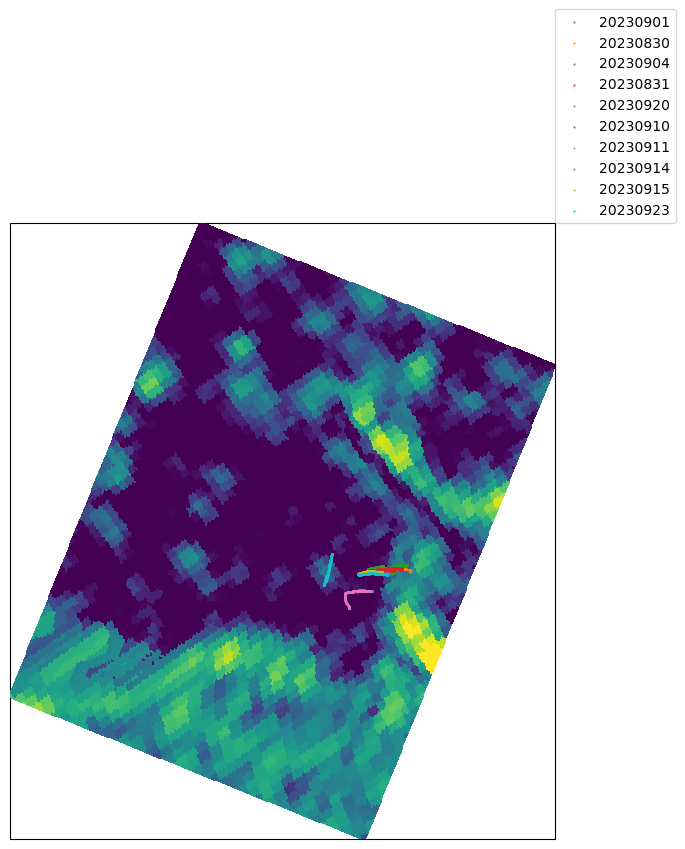

In [9]:

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())


ax.set_extent([ np.nanmax(longrid),
               np.nanmin(longrid-0.1),
               np.nanmax(latgrid),
               np.nanmin(latgrid)], ccrs.PlateCarree())
    

x0=750;y0=950
x1=900;y1=1150

log = longrid[x0:x1,y0:y1]
lag = latgrid[x0:x1,y0:y1]

ax.set_extent([ np.nanmax(log),
               np.nanmin(log),
               np.nanmax(lag),
               np.nanmin(lag)], ccrs.PlateCarree())
    

ax.pcolormesh(log,lag,data[x0:x1,y0:y1],
             transform=ccrs.PlateCarree(),zorder=10)

for date in positions:
    lons = positions[date]['lon']
    lats = positions[date]['lat']
    
    ax.scatter(lons,lats,transform=ccrs.PlateCarree(),zorder=10,marker='.',s=1,label=date)

    # break

# # ax.set_title(df.iloc[i]['file'].split('PROCESSED')[1],fontsize='x-large')

# plt.savefig(f"locations_photos/{df.iloc[i]['file'].split('/')[-1][:-3]}.png",dpi=300)
# plt.close()
ax.legend(loc=(1,1))
plt.show()

In [10]:
import matplotlib as mpl
name = "Set1"
cmap = mpl.colormaps[name]  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
c = list(colors)+['k']

In [11]:
px=positions_xy['20230901']['x']
py=positions_xy['20230901']['y']

In [12]:
x0,y0=px[0],py[0]

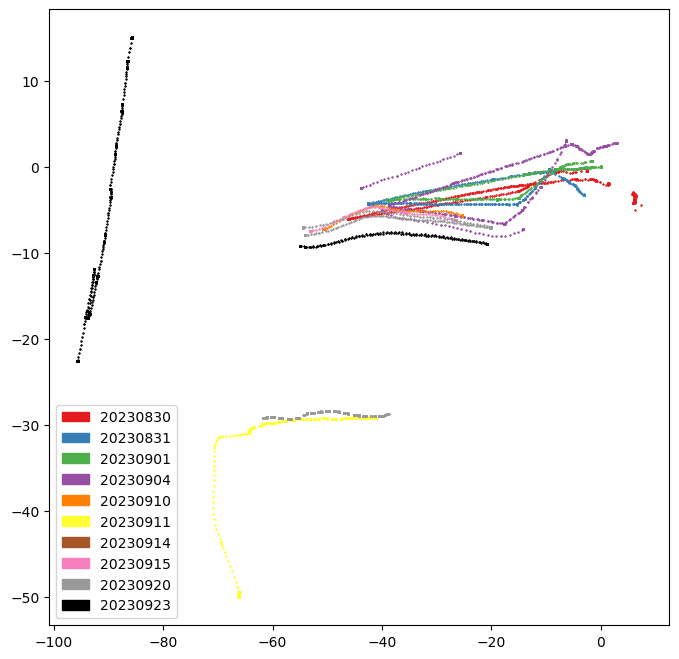

In [13]:

fig,ax = plt.subplots(1,1,figsize=(8,8))

pos_list = sorted(positions.keys())
for date,color in zip(pos_list,c):
    x = np.array(positions_xy[date]['x'])-x0
    y = np.array(positions_xy[date]['y'])-y0
    
    y=y[x<2000000]
    x=x[x<2000000]

    y=y[x<50]
    x=x[x<50]
    
    ax.scatter(x,y,marker='.',s=1,color=color)

    ax.fill_between([],[],color=color,label=date)
    # break
    # break

# # ax.set_title(df.iloc[i]['file'].split('PROCESSED')[1],fontsize='x-large')

# plt.savefig(f"locations_photos/{df.iloc[i]['file'].split('/')[-1][:-3]}.png",dpi=300)
# plt.close()
ax.legend()
plt.show()